In [21]:
import numpy as np
import matplotlib.pyplot as plt

raw_dset = np.load(
    "/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/npz_datasets/soapgpu_ns1000_5000-5050_dx2_sm3_p60_k1_phi0.npz",
    allow_pickle=True
)

print(raw_dset.files)

wavegrid = raw_dset["wavegrid"]
template = raw_dset["template"]
spectra = raw_dset["spectra"]
activity = raw_dset["activity"]
time_values = raw_dset["time_values"]
v_true = raw_dset["v_true"]
metadata = raw_dset["metadata"].item()
spectra_no_activity = raw_dset["spectra_no_activity"]

ccf_data = np.load(
    "/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/ccf_results/ccf_analysis_results.npz"
)

print(ccf_data.files)

all_rvs_ccf = ccf_data["rvs"]
all_time_values = ccf_data["time_values"]
random_ccf = ccf_data["raw_ccfs"][np.random.randint(0, ccf_data["raw_ccfs"].shape[0])]
v_grid_ccf = ccf_data["v_grid"]

['wavegrid', 'template', 'spectra', 'activity', 'time_values', 'v_true', 'metadata', 'spectra_no_activity']
['rvs', 'depths', 'fwhms', 'spans', 'continuum', 'amplitude', 'raw_ccfs', 'v_grid', 'wavegrid', 'time_values', 'metadata']


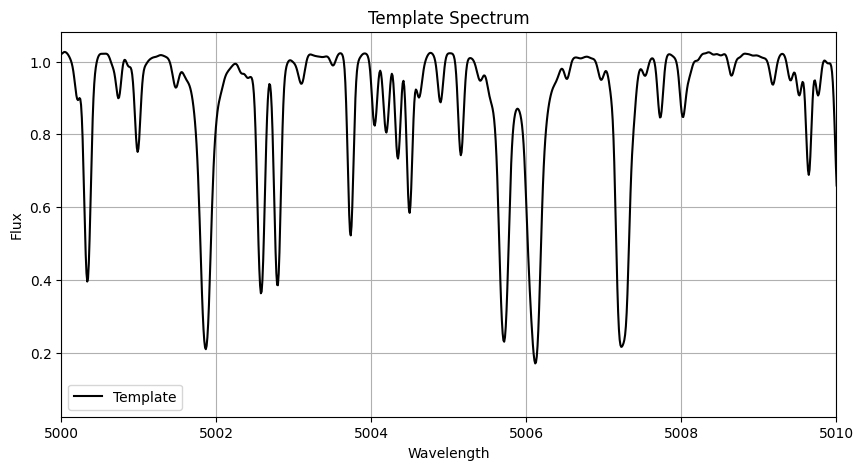

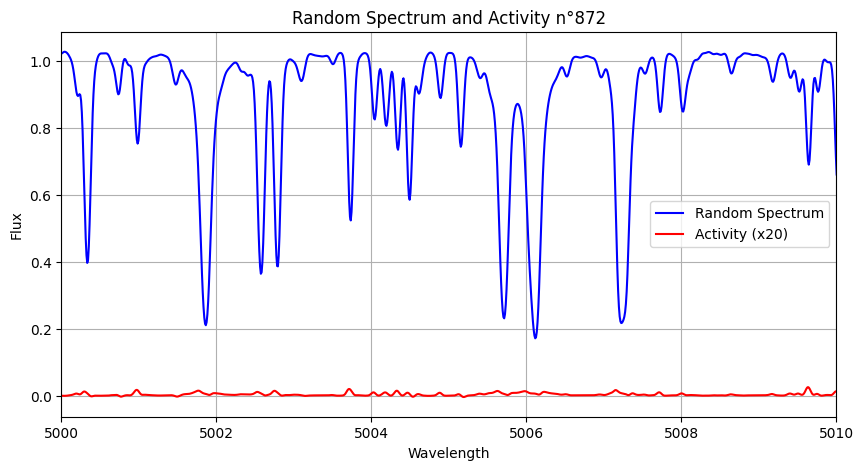

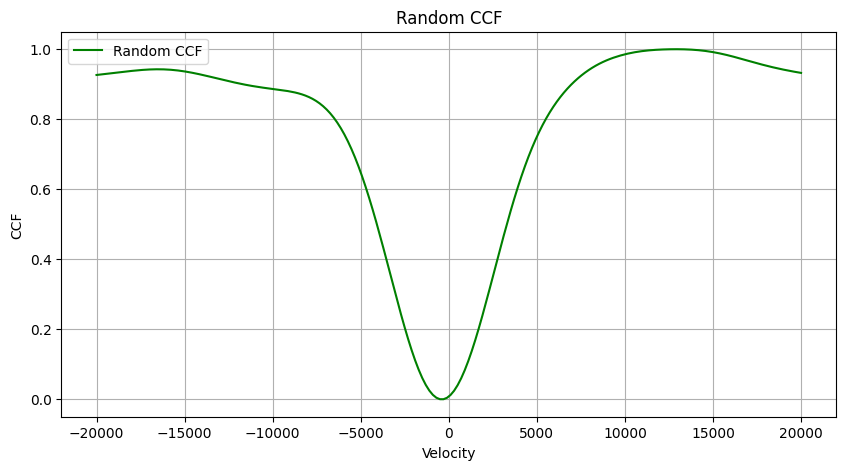

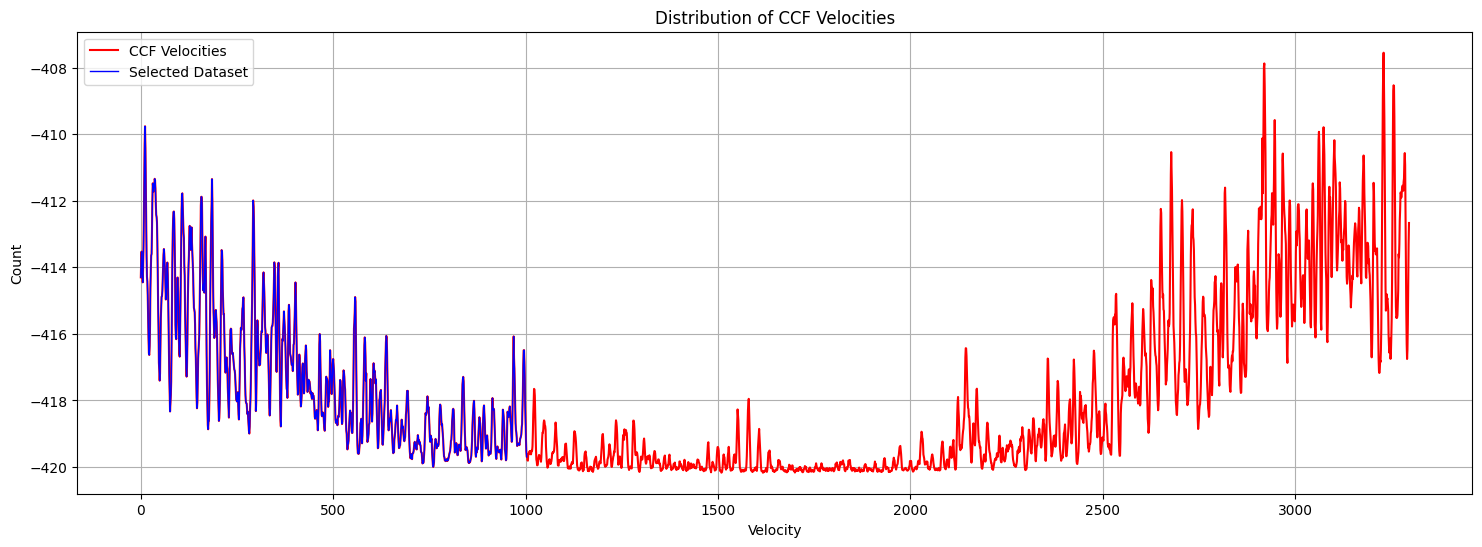

In [29]:
xlim = (5000, 5010)
# Plot du template

plt.figure(figsize=(10, 5))
plt.plot(wavegrid, template, color="k", label="Template")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.grid()
plt.title("Template Spectrum")
plt.xlim(xlim)
plt.legend()
plt.show()

# Plot d'un spectre random et de son activity (x 20)

random_index = np.random.randint(0, spectra.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(wavegrid, spectra[random_index], color="b", label="Random Spectrum")
plt.plot(wavegrid, 50 * activity[random_index], color="r", label="Activity (x20)")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.grid()
plt.title(f"Random Spectrum and Activity n°{random_index}")
plt.legend()
plt.xlim(xlim)
plt.show()

# Plot d'une ccf random
plt.figure(figsize=(10, 5))
plt.plot(v_grid_ccf, random_ccf, color="g", label="Random CCF")
plt.xlabel("Velocity")
plt.ylabel("CCF")
plt.grid()
plt.title(f"Random CCF")
plt.legend()
plt.show()

# Plot des vitesses obtenues par ccf sur tout le dset
plt.figure(figsize=(18, 6))
plt.plot(all_time_values, all_rvs_ccf, color="red", label="CCF Velocities")
plt.plot(all_time_values[time_values], all_rvs_ccf[time_values], color="blue", linewidth=1,label="Selected Dataset")
plt.xlabel("Velocity")
plt.ylabel("Count")
plt.grid()
plt.title(f"Distribution of CCF Velocities")    
plt.legend()
plt.show()
